# Quantum benchmark

## I - Introduction

## II - Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_score, KFold
#Import classical libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt
from skpp import ProjectionPursuitRegressor

plt.style.use('ggplot')

import functools

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data
import logging

import pennylane as qml
from pennylane.templates.embeddings import AngleEmbedding, AmplitudeEmbedding
from pennylane.optimize import AdamOptimizer

from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
import qiskit

In [2]:
import warnings
warnings.filterwarnings('ignore')

## III - Data 

In [3]:
# Read out CSV

df = pd.read_csv('santander_transaction.csv', sep=',')
df = df.sample(1000)

In [4]:
df.shape

(1000, 201)

In [10]:
%%script false --no-raise-error

import sweetviz as sv

#EDA using Autoviz
sweet_report = sv.analyze(df)

#Saving results to HTML file
sweet_report.show_html('sweet_report.html')

## IV - Modelisation

### Classical

In [5]:
df_labels = df['target']
df.drop(['target'],axis = 1,inplace = True)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df, df_labels, test_size=0.2, random_state=42)

## Quantum Approaches

In [13]:
np.unique(df_labels)

array([0, 1])

In [7]:
skpp = ProjectionPursuitRegressor(r=2, fit_type='spline', opt_level='medium').fit(X_train, y_train)

In [8]:
# SKPP validate transformation (using train fit)
x_train_skpp = skpp.transform(X_train)
x_test_skpp = skpp.transform(X_test)

In [9]:
# Arrays to dataframe for join in a single df
x_train_skpp = pd.DataFrame(x_train_skpp)
x_test_skpp = pd.DataFrame(x_test_skpp)

In [10]:
# Second standard scaler normalization (using train fit)
std_scale = StandardScaler().fit(x_train_skpp)
X_train_skpp_norm = std_scale.transform(x_train_skpp)
x_test_skpp_norn = std_scale.transform(x_test_skpp)
#x_validate_lda_n = std_scale.transform(x_validate_skpp)

In [11]:
# Dimensions definition for QML
n_dim = len(x_train_skpp.columns)
n_dim

2

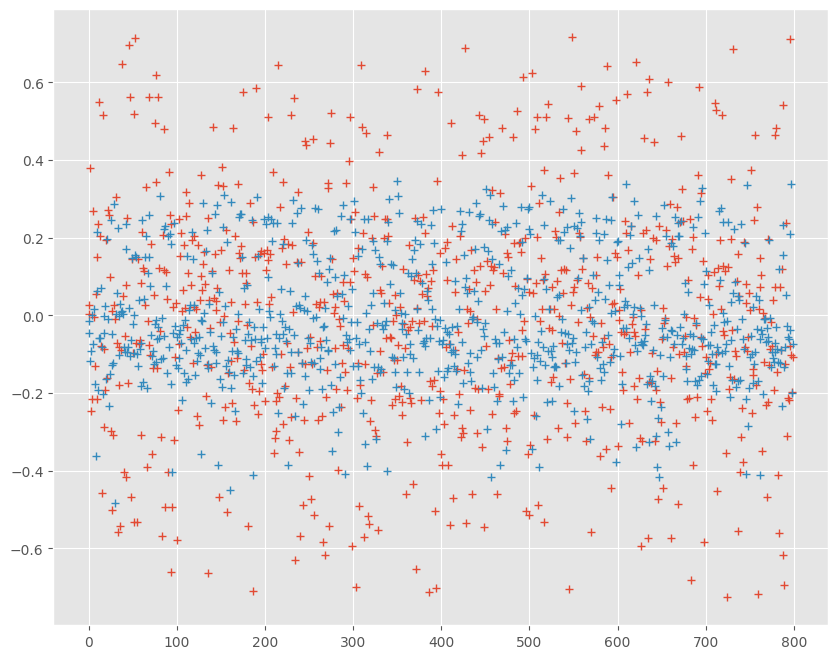

In [12]:
plt.figure(figsize=(10,8))
plt.plot(x_train_skpp, '+')


## Split train test 

In [23]:
%%script false --no-raise-error

# Split dataset into train and test

sample_train, sample_test, label_train, label_test = train_test_split(
     X_train_skpp_norm, y_train, test_size=0.2, random_state=22)

# Normalize

# Select a sample for a better control of the research and wall time

train_size = 800#160
sample_train = sample_train[:train_size]
label_train = label_train[:train_size]

test_size = 200 #40
sample_test = sample_test[:test_size]
label_test = label_test[:test_size]

In [13]:
sample_train, label_train, sample_test, label_test = X_train_skpp_norm, y_train, x_test_skpp_norn, y_test

In [14]:
# Basic parameters for hybrid model

seed = 8500
feature_dim = n_dim
num_reps = 2
num_shots =256 


## Hybrid

In [16]:
# Define feature_map

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=num_reps)

# Define the backend
backend = QuantumInstance(
    BasicAer.get_backend("qasm_simulator"), shots=num_shots, seed_simulator=seed, seed_transpiler=seed
)

# Define the kernel

kernel = QuantumKernel(feature_map=feature_map, quantum_instance=backend)

# Model run
svc = SVC(kernel=kernel.evaluate)
#svc.fit(sample_train, label_train)
#score = svc.score(sample_test, label_test)

#print(f"Callable kernel classification test score: {score}")

In [27]:
#result_predict = svc.predict(sample_test)

In [15]:
#print(metrics.classification_report(label_test,result_predict))

In [17]:
from sklearn.model_selection import cross_validate
from tqdm import tqdm
def evaluate_ml_model(_models, X, y, n_fold=10, metric='precision'):
    ''' Function to evaluate a ML and QML model with a list of metrics
    
    
    '''
    results = pd.DataFrame()
    kfold = KFold(n_splits=n_fold)
    columns = []
    for name, model in tqdm(_models):
        # -------------------
        # Variables initialization 
        _df = pd.DataFrame()
        names = []
        means = []
        stds = []
        
        # -------------------
        # k-fold Cross validation
        cv_results = cross_validate(model, X, y, cv=kfold, scoring=metric)
        
        # -------------------
        # Compute the mean and standard deviation 
        for _name, _array in cv_results.items():
            names.append(_name)
            means.append(round(100*_array.mean(), 2))
            stds.append(round(100*_array.std(), 2))
        # -------------------
        # Save the results in a dataframe 
        _df =  pd.DataFrame([means, stds], columns=names)
        columns.extend([name+' mean (%)', name+' std (%)'])
        #results = results.join(_df, on=_df.index)
        results = results.append(_df)
    results.index = columns
    print(results)
    return results

In [38]:
models = []
models.append(('LR', LogisticRegression(max_iter=1000, random_state=42)))
models.append(('KNN', KNeighborsClassifier(n_neighbors=7)))
models.append(('CART', DecisionTreeClassifier(random_state=42)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=42)))
models.append(('QSVC', svc))

_metrics = ['precision', 'recall', 'f1', 'accuracy',  'matthews_corrcoef','balanced_accuracy']


In [39]:
df_results = pd.DataFrame()
df_results = evaluate_ml_model(models, sample_train, label_train, n_fold=10, metric=_metrics)
df_results 

100%|███████████████████████████████████████████| 1/1 [58:41<00:00, 3521.39s/it]

               fit_time  score_time  test_precision  test_recall  test_f1  \
QSVC mean (%)  29166.03     6047.68           62.96        66.30    63.87   
QSVC std (%)    1205.86      740.83           12.97         6.73     8.41   

               test_accuracy  test_matthews_corrcoef  test_balanced_accuracy  
QSVC mean (%)          61.62                   24.24                   62.20  
QSVC std (%)            7.77                   14.15                    7.22  


,fit_time,score_time,test_precision,test_recall,test_f1,test_accuracy,test_matthews_corrcoef,test_balanced_accuracy
QSVC mean (%),29166.03,6047.68,62.96,66.30,63.87,61.62,24.24,62.20
QSVC std (%),1205.86,740.83,12.97,6.73,8.41,7.77,14.15,7.22


In [40]:
j = 0
for i in range(int(len(df_results.index)/2)):

    print(f'{df_results.iloc[j].name.split()[0]} & {df_results.iloc[j][2]} ({df_results.iloc[j+1][2]}) & {df_results.iloc[j][3]} ({df_results.iloc[j+1][3]}) &  {df_results.iloc[j][4]} ({df_results.iloc[j+1][4]}) & {df_results.iloc[j][6]} ({df_results.iloc[j+1][6]}) & {df_results.iloc[j][7]} ({df_results.iloc[j+1][7]}) \\')
    
    j+=2

QSVC & 62.96 (12.97) & 66.3 (6.73) &  63.87 (8.41) & 24.24 (14.15) & 62.2 (7.22) \


## Pennylane

In [21]:
from pennylane import numpy as np

In [22]:
# Angle Encoding

num_qubits = n_dim

dev = qml.device('default.qubit', wires = num_qubits)

@qml.qnode(dev)
def circuit(parameters, data):
    for i in range(num_qubits):
        qml.Hadamard(wires = i)
    
    AngleEmbedding(features = data, wires = range(num_qubits), rotation = 'Y')
    
    qml.StronglyEntanglingLayers(weights = parameters, wires = range(num_qubits))
    
    return qml.expval(qml.PauliZ(0))

In [23]:
num_layers = 5
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

#print(weights_init, bias_init)

In [24]:
circuit(weights_init, sample_train[0])

tensor(-0.00666193, requires_grad=True)

In [25]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In [26]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [27]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [28]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [29]:
pd.Series(label_test).value_counts()

1.0    105
0.0     95
Name: target, dtype: int64

In [30]:
Y = np.array(label_train * 2 - np.ones(len(label_train)),requires_grad=True)  # shift label from {0, 1} to {-1, 1}
X = np.array(sample_train, requires_grad=True)

for i in range(5):
    print("X = {}, Y = {: d}".format(list(X[i]), int(Y[i])))

X = [tensor(0.01433546, requires_grad=True), tensor(-0.01934006, requires_grad=True)], Y = -1
X = [tensor(0.0948825, requires_grad=True), tensor(-0.20105589, requires_grad=True)], Y = -1
X = [tensor(1.31103768, requires_grad=True), tensor(-0.64957521, requires_grad=True)], Y =  1
X = [tensor(-0.85007218, requires_grad=True), tensor(-0.48398223, requires_grad=True)], Y = -1
X = [tensor(-0.74376708, requires_grad=True), tensor(0.08335349, requires_grad=True)], Y = -1


In [31]:
opt = AdamOptimizer(stepsize=0.1, beta1=0.9, beta2=0.99, eps=1e-08)
batch_size = 10

In [32]:
weights = weights_init
bias = bias_init

wbest = 0
bbest = 0
abest = 0
ccost = 0 
for it in range(150):

    # weights update by one optimizer step

    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute the accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    
    '''if accuracy(Y, predictions) > abest:
        wbest = weights
        bbest = bias
        abest = accuracy(Y, predictions)
        print('New best')

    acc = accuracy(Y, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), acc
        )
    )'''
    prec = metrics.f1_score(Y, predictions, average='binary', pos_label=1)
    if  prec > abest or ((prec == abest) and (cost(weights, bias, X, Y) < ccost)):
        wbest = weights
        bbest = bias
        abest = prec
        ccost = cost(weights, bias, X, Y)
        print('New best')
    #prec = metrics.precision_score(Y, predictions, average='binary')
    print(
        "Iter: {:5d} | Cost: {:0.7f} | f1: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), prec
        )
    )
    
    

New best
Iter:     1 | Cost: 1.1117618 | f1: 0.4283604 
New best
Iter:     2 | Cost: 1.0075989 | f1: 0.4507513 
Iter:     3 | Cost: 1.0866756 | f1: 0.3518164 
Iter:     4 | Cost: 0.9329551 | f1: 0.4496403 
New best
Iter:     5 | Cost: 0.7349684 | f1: 0.6352584 
New best
Iter:     6 | Cost: 0.6834494 | f1: 0.7784291 
Iter:     7 | Cost: 0.6637075 | f1: 0.7659091 
New best
Iter:     8 | Cost: 0.6282124 | f1: 0.7812142 
New best
Iter:     9 | Cost: 0.5882258 | f1: 0.8082192 
New best
Iter:    10 | Cost: 0.5349284 | f1: 0.8888889 
New best
Iter:    11 | Cost: 0.5055548 | f1: 0.8997613 
Iter:    12 | Cost: 0.5311958 | f1: 0.8482490 
Iter:    13 | Cost: 0.5900168 | f1: 0.7615283 
Iter:    14 | Cost: 0.5848280 | f1: 0.7610619 
Iter:    15 | Cost: 0.5586770 | f1: 0.7837838 
Iter:    16 | Cost: 0.5282831 | f1: 0.8206331 
Iter:    17 | Cost: 0.5091342 | f1: 0.8513514 
Iter:    18 | Cost: 0.5101376 | f1: 0.8555917 
Iter:    19 | Cost: 0.4892950 | f1: 0.8778878 
New best
Iter:    20 | Cost: 0.4682

In [33]:
Yte = np.array(label_test * 2 - np.ones(len(label_test)))
Xte = np.array(normalize(sample_test))

In [34]:
pd.Series(Yte).value_counts()

 1.0    105
-1.0     95
dtype: int64

In [35]:
predictions = [np.sign(variational_classifier(wbest, bbest, x)) for x in Xte]
pred = [np.sign(variational_classifier(wbest, bbest, x)) for x in X]
acc = accuracy(Yte, predictions)

print(f'Cost: {cost(wbest, bbest, Xte, Yte)}, Accuracy: {np.round(acc, 2) * 100}%')

Cost: 0.8867982401248026, Accuracy: 66.0%


In [36]:
print(metrics.classification_report(Yte,predictions))

              precision    recall  f1-score   support

        -1.0       0.64      0.61      0.63        95
         1.0       0.66      0.70      0.68       105

    accuracy                           0.66       200
   macro avg       0.65      0.65      0.65       200
weighted avg       0.65      0.66      0.65       200



In [37]:
print(f'''

    Precision: {round(100*metrics.precision_score(predictions,Yte),2)}%
    Recall: {round(100*metrics.recall_score(predictions,Yte),2)}%
    f1: {round(100*metrics.f1_score(predictions,Yte),2)}%
    Accuracy: {round(100*metrics.accuracy_score(predictions,Yte),2)}%
    Matthew corcorref: {round(100*metrics.matthews_corrcoef(predictions,Yte),2)}%
    Balanced accuracy: {round(100*metrics.balanced_accuracy_score(predictions,Yte),2)}%
    ''')



    Precision: 69.52%
    Recall: 66.36%
    f1: 67.91%
    Accuracy: 65.5%
    Matthew corcorref: 30.69%
    Balanced accuracy: 65.4%
    


In [ ]:
weights = weights_init
bias = bias_init

wbest = 0
bbest = 0
abest = 0
ccost = 1 
for it in range(150):

    # weights update by one optimizer step

    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute the accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    
    '''if accuracy(Y, predictions) > abest:
        wbest = weights
        bbest = bias
        abest = accuracy(Y, predictions)
        print('New best')

    acc = accuracy(Y, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), acc
        )
    )'''
    prec = accuracy(Y, predictions)
    if  prec > abest or ((prec == abest) and (cost(weights, bias, X, Y) < ccost)):
        wbest = weights
        bbest = bias
        abest = prec
        ccost = cost(weights, bias, X, Y)
        print('New best')
    #prec = metrics.precision_score(Y, predictions, average='binary')
    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), prec
        )
    )
    
    

New best
Iter:     1 | Cost: 1.1388050 | Accuracy: 0.4800000 
New best
Iter:     2 | Cost: 1.0274811 | Accuracy: 0.5637500 
New best
Iter:     3 | Cost: 0.8905291 | Accuracy: 0.6575000 
New best
Iter:     4 | Cost: 0.7579426 | Accuracy: 0.7612500 
New best
Iter:     5 | Cost: 0.6521451 | Accuracy: 0.8512500 
Iter:     6 | Cost: 0.6235211 | Accuracy: 0.8075000 
Iter:     7 | Cost: 0.6576260 | Accuracy: 0.7550000 
Iter:     8 | Cost: 0.6438223 | Accuracy: 0.7712500 
Iter:     9 | Cost: 0.6215416 | Accuracy: 0.7787500 
Iter:    10 | Cost: 0.5751959 | Accuracy: 0.7900000 
Iter:    11 | Cost: 0.5487399 | Accuracy: 0.8062500 
Iter:    12 | Cost: 0.5385611 | Accuracy: 0.8087500 
Iter:    13 | Cost: 0.5272715 | Accuracy: 0.8125000 
Iter:    14 | Cost: 0.5199479 | Accuracy: 0.8125000 
Iter:    15 | Cost: 0.5239588 | Accuracy: 0.8212500 
Iter:    16 | Cost: 0.5270090 | Accuracy: 0.8162500 
Iter:    17 | Cost: 0.5128352 | Accuracy: 0.8212500 
New best
Iter:    18 | Cost: 0.4497494 | Accuracy: 0.8

In [ ]:
predictions = [np.sign(variational_classifier(wbest, bbest, x)) for x in Xte]
pred = [np.sign(variational_classifier(wbest, bbest, x)) for x in X]
acc = accuracy(Yte, predictions)

print(f'Cost: {cost(wbest, bbest, Xte, Yte)}, Accuracy: {np.round(acc, 2) * 100}%')

In [ ]:
print(metrics.classification_report(Yte, predictions))

In [ ]:
print(f'''

    Precision: {round(100*metrics.precision_score(predictions,Yte),2)}%
    Recall: {round(100*metrics.recall_score(predictions,Yte),2)}%
    f1: {round(100*metrics.f1_score(predictions,Yte),2)}%
    Accuracy: {round(100*metrics.accuracy_score(predictions,Yte),2)}%
    Balanced accuracy: {round(100*metrics.balanced_accuracy_score(predictions,Yte),2)}%
    Matthew corcorref: {round(100*metrics.matthews_corrcoef(predictions,Yte),2)}%
    ''')